# Right-Back Recruitment Framework (Section 2)

Goal: rank RB/RWB candidates for a Wilder-style 3-5-2/5-3-2 using pillars (Build-up, Creation, Defending), small bonuses, and a feasibility overlay.

In [1]:
import os, sys
sys.path.append(os.path.abspath("."))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src import utils, features, scoring

## Parameters & column mapping (editable)
Purpose: Make choices transparent and tweakable in one place.

In [2]:
# Columns
POSITION_COL = "Position"
LEAGUE_COL = "League"
MINUTES_COL = "Minutes"
AGE_COL = "Age"
VALUE_COL = "(€) Market Value"
CONTRACT_COL = "Contract End"
GBE_COL = "GBE"

# Eligibility
ELIG_POS = {"DR","DMR"}
MIN_MINUTES_ELIG = 1000

# Per90 (counting stats only)
COUNTING_COLS = [
    "Goals","Assists","Expected Assists","Open Play Key Passes",
    "Completed Crosses","Progressive Carries","Ball Prog. by Carrying",
    "Successful Tackles","Interceptions"
]

# Pillars tuned to SUFC Wilder context
from src.features import BUILD_UP, CREATION, DEFENDING

PILLAR_WEIGHTS = {"BuildUp":0.40,"Creation":0.35,"Defending":0.25}

# Bonuses (small & transparent)
AGE_RANGE = (20,27); AGE_BONUS = 0.10
MIN_MINUTES = 1800; MIN_BONUS = 0.05

# Feasibility weights and shortlist size
FEAS_W = {"value":0.6, "contract":0.3, "gbe":0.1}
TOP_N = 12

In [3]:
# Load & eligibility cohort
DATA_PATH = "./data/SUFC Data Scientist RB Export 2024-25 (Complete).csv"
df = utils.load_data(DATA_PATH)

eligible = df[df[POSITION_COL].astype(str).isin(ELIG_POS)].copy()
eligible = eligible[eligible[MINUTES_COL].fillna(0) >= MIN_MINUTES_ELIG]
print("Eligible cohort:", eligible.shape)

Eligible cohort: (48, 147)


In [4]:
# Per90 creation (safe)
present_counting = [c for c in COUNTING_COLS if c in eligible.columns]
eligible_p90 = scoring.make_per90(eligible, present_counting, minutes_col=MINUTES_COL)

In [5]:
# League-aware standardisation (z-scores)
all_metrics = features.available(eligible_p90, BUILD_UP + CREATION + DEFENDING)
standardised = scoring.zscore_by_group(eligible_p90, all_metrics, group_col=LEAGUE_COL)

In [6]:
# Pillar scores
standardised["BuildUp"] = scoring.pillar_score(standardised, features.available(standardised, BUILD_UP))
standardised["Creation"] = scoring.pillar_score(standardised, features.available(standardised, CREATION))
standardised["Defending"] = scoring.pillar_score(standardised, features.available(standardised, DEFENDING))

In [7]:
# Recruitment score + bonuses
standardised["Overall"] = scoring.overall_score(standardised, PILLAR_WEIGHTS)
standardised["Bonuses"] = scoring.apply_bonuses(
    standardised, age_col=AGE_COL, minutes_col=MINUTES_COL,
    age_range=AGE_RANGE, min_minutes=MIN_MINUTES,
    age_bonus=AGE_BONUS, min_bonus=MIN_BONUS
)
standardised["Recruitment_Score"] = standardised["Overall"] + standardised["Bonuses"]

In [8]:
# Feasibility overlay
standardised["Feasibility_Score"] = scoring.feasibility(
    standardised, value_col=VALUE_COL, contract_col=CONTRACT_COL, gbe_col=GBE_COL, weights=FEAS_W
)
standardised["Priority_Score"] = standardised["Recruitment_Score"] * standardised["Feasibility_Score"]

In [9]:
# Risk flags (scout notes)
standardised["Flags"] = scoring.make_flags(standardised)

In [10]:
# Shortlist table (export)
cols_out = ["Name","Team","League",AGE_COL,MINUTES_COL,VALUE_COL,
            "BuildUp","Creation","Defending","Overall","Bonuses",
            "Recruitment_Score","Feasibility_Score","Priority_Score","Flags"]
shortlist = (standardised[[c for c in cols_out if c in standardised.columns]]
             .sort_values(["Priority_Score","Recruitment_Score"], ascending=False)
             .head(TOP_N))

from IPython.display import display

display(shortlist)
out_path = "./outputs/shortlist.csv"
shortlist.to_csv(out_path, index=False)
print("Saved:", out_path)

,Name,Team,Age,Minutes,(€) Market Value,BuildUp,Creation,Defending,Overall,Bonuses,Recruitment_Score,Feasibility_Score,Priority_Score,Flags
45,Fraser Murray,Wigan Athletic,26,1010,375.0,-0.338207,2.109031,0.080842,0.623088,0.10,0.723088,0.807326,0.583768,Low minutes
7,Pedro Porro,Tottenham,26,2950,38000.0,0.280035,1.712979,0.086810,0.733259,0.15,0.883259,0.253850,0.224215,
18,Matheus Nunes,Manchester City,27,1881,35000.0,1.133373,0.101167,0.310053,0.566271,0.15,0.716271,0.261572,0.187357,
13,Amad Diallo,Manchester United,23,2127,45000.0,1.390391,0.888988,-0.378525,0.772671,0.15,0.922671,0.177972,0.164209,
42,Remeao Hutton,Gillingham,27,1032,275.0,-1.465761,1.891277,0.184810,0.121845,0.10,0.221845,0.716362,0.158922,Low minutes
43,Tom Barkhuizen,Barrow,32,1032,300.0,0.035509,0.829758,-0.327379,0.222774,0.00,0.222774,0.708219,0.157773,Low minutes
26,Kieran Trippier,Newcastle,35,1465,4000.0,0.231126,0.740392,-0.163629,0.310681,0.00,0.310681,0.465251,0.144545,
31,Mats Wieffer,Brighton,25,1233,25000.0,0.290733,-0.372433,1.449611,0.348344,0.10,0.448344,0.293170,0.131441,
1,Aaron Wan Bissaka,West Ham United,27,3551,24000.0,1.115394,0.360997,-0.030652,0.564844,0.15,0.714844,0.177004,0.126530,
3,Kyle Walker Peters,Southampton,28,3265,15000.0,1.493280,-0.065402,-1.199230,0.274614,0.05,0.324614,0.341140,0.110739,Progressive; 1v1 risk


Saved: ./outputs/shortlist.csv


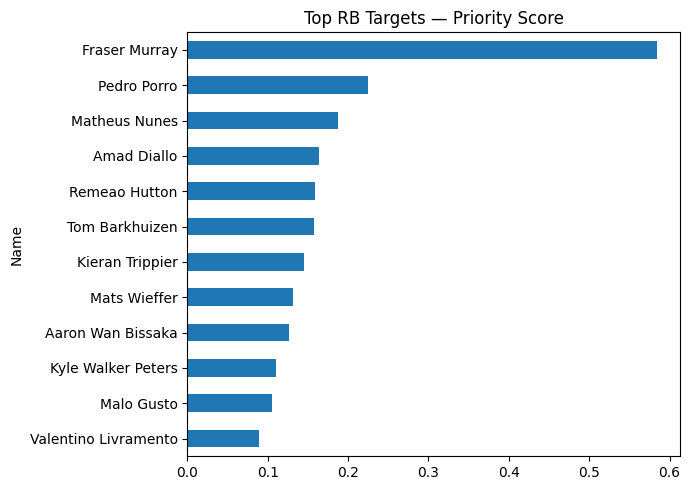

In [11]:
# Visual add-ons (optional, fast wins)
ax = shortlist.set_index("Name")["Priority_Score"].plot(kind="barh", figsize=(7,5), title="Top RB Targets — Priority Score")
ax.invert_yaxis(); plt.tight_layout(); plt.show()


In [ ]:
# Sensitivity 
def rerank_with(weights_delta):
    w = PILLAR_WEIGHTS.copy()
    for k, dv in weights_delta.items():
        w[k] = max(0, w.get(k,0) + dv)
    s = standardised.copy()
    s["Overall_tmp"] = scoring.overall_score(s, w)
    s["Recruitment_tmp"] = s["Overall_tmp"] + s["Bonuses"]
    s["Priority_tmp"] = s["Recruitment_tmp"] * s["Feasibility_Score"]
    return s.sort_values("Priority_tmp", ascending=False).head(TOP_N)[["Name","Priority_tmp"]]

alt_creation = rerank_with({"Creation": +0.10, "BuildUp": -0.05, "Defending": -0.05})
alt_defend = rerank_with({"Defending": +0.10, "BuildUp": -0.05, "Creation": -0.05})

from IPython.display import display

display(alt_creation.head(10))
display(alt_defend.head(10))


,Name,Priority_tmp
45,Fraser Murray,0.764424
42,Remeao Hutton,0.340287
7,Pedro Porro,0.263043
43,Tom Barkhuizen,0.226874
26,Kieran Trippier,0.177421
18,Matheus Nunes,0.171125
13,Amad Diallo,0.171027
1,Aaron Wan Bissaka,0.123320
44,Kyran Lofthouse,0.109081
3,Kyle Walker Peters,0.103492


,Name,Priority_tmp
45,Fraser Murray,0.518813
7,Pedro Porro,0.201122
44,Kyran Lofthouse,0.185077
18,Matheus Nunes,0.179321
31,Mats Wieffer,0.175137
42,Remeao Hutton,0.156920
13,Amad Diallo,0.137189
26,Kieran Trippier,0.114332
1,Aaron Wan Bissaka,0.112921
12,Malo Gusto,0.111050
